# Chris Lomont, learning Julia, Oct 2020

Implement a raytracer, follow https://github.com/RayTracing/raytracing.github.io

Writing a raytracer, self made types to learn

In [1]:
# import Pkg; Pkg.add("Traceur")
using Traceur # for performance tuning

In [2]:
# Basic vector type
# Simply make vectors as v = [1;2;3]
# vector functions  +-*/,length, length_squared, print, alias for color and point, print, dot, cross, unit length
using LinearAlgebra
# import Pkg; Pkg.add("StaticArrays") # if not present
using StaticArrays
Vec3 = SVector{3,Float64}

# vector helpers - make unit length vector

unit_vector(v::Vec3) = v/norm(v)

#function unit_vector(v::Vec3)    
#    v/norm(v)
#end

unit_vector (generic function with 1 method)

In [3]:
# some type aliases
Point3 = Vec3
Color  = Vec3

SArray{Tuple{3},Float64,1,3}

In [4]:
# color utility, converts 0-1 to text 0-255
function to255(v); convert(Int32,round(255v)); end

Base.show(io::IO, c::Color) = print(io,"$(to255(c[1])) $(to255(c[2])) $(to255(c[3]))")

function clean_color(pixel_color,samples_per_pixel)
    scale = 1.0/convert(Float64,samples_per_pixel)
    
    # sqrt for gamma correct 2.0
    r = sqrt(pixel_color[1]*scale)
    g = sqrt(pixel_color[2]*scale)
    b = sqrt(pixel_color[3]*scale)
    
    r = clamp(r,0.0,0.999)
    g = clamp(g,0.0,0.999)
    b = clamp(b,0.0,0.999)
    Color(r,g,b)
end


clean_color (generic function with 1 method)

In [5]:
# random number utils

# Returns a random real in [0,1).
random_double() = rand()

# Returns a random real in [min,max).
function random_double( min, max) 
    min + (max-min)*random_double()
end

# random in unit cube
function random_vec()
    Vec3(random_double(),random_double(),random_double())
end
# random in cube
function random_vec(min,max)
    Vec3(random_double(min,max),random_double(min,max),random_double(min,max))
end
    
function random_unit_vector() 
    a = random_double(0, 2*pi);
    z = random_double(-1, 1);
    r = sqrt(1 - z*z);
    Vec3(r*cos(a), r*sin(a), z);
end

function random_in_unit_sphere()
    while true
        p = random_vec(-1.0,1.0)
        if norm(p) < 1
            return p
        end
    end
end

function random_in_hemisphere(normal) 
    in_unit_sphere = random_in_unit_sphere();
    if dot(in_unit_sphere, normal) > 0.0 #// In the same hemisphere as the normal
        return in_unit_sphere;
    else
        return -in_unit_sphere;
    end
end

function random_in_unit_disk()
    while true
        p = Vec3(random_double(-1,1), random_double(-1,1), 0)
        if norm(p) >= 1 
            continue
        end
        return p
    end
end

# Returns a random integer in [min,max].
function random_int(min, max) 
    convert(Int64,floor(random_double(min, max+1)))
end

# random_in_hemisphere(Vec3(1,0,0))
# random_in_unit_disk()
random_int(10,11)


11

In [6]:
# math utils
function degrees_to_radians(degrees)
    # π
    # α
    π * degrees / 180.0    
end
function clamp(x,min,max)
    if x < min
        return min
    elseif max < x
        return max
    end
    x
end
# degrees_to_radians(90)

clamp (generic function with 1 method)

In [7]:
# a simple Ray item
struct Ray
    origin    :: Point3
    direction :: Vec3
    time      :: Float64
end

function Ray()
    Ray(Point3(0,0,0),Vec3(0,0,1),0.0)
end

function ray_at(r::Ray, t::Float64)
    r.origin + t * r.direction
end    

ray_at (generic function with 1 method)

In [8]:
# base material type
abstract type Material end


In [9]:
# derived from this to be hittable by a ray
abstract type Hittable end

# abstract hits
struct HitRecord{M<:Material}
    p::Point3    # intersection point
    normal::Vec3 # points away from ray
    material::M  # material hit
    t::Float64   # parameter along ray line
    u::Float64   # texture coords
    v::Float64   # texture coords
    front_face::Bool # side was hit on
end

# return an empty hit
function HitRecord()
    HitRecord(Vec3(0,0,0),Vec3(1,0,0),Metal(Color(0.0,0.0,0.0),0.0),0.0,0.0,0.0,true)    
end

# given a ray, and the outward surface normal, return if ray hits front face
function is_front(r::Ray, outward_normal::Vec3)
    dot(r.direction,outward_normal) < 0    
end


is_front (generic function with 1 method)

In [10]:
# bounding boxes and hierarchical tree
# speeds up ray object intersections
struct AABB # Axis-Aligned Bounding Box
    min::Point3
    max::Point3
end

# does ray hit box?
function hit(b::AABB, r::Ray, tmin::Float64, tmax::Float64)
    for i in 1:3
        inv = 1.0 / r.direction[i]
        t0 = (b.min[i] - r.origin[i]) * inv
        t1 = (b.max[i] - r.origin[i]) * inv
        if inv < 0
            t0,t1 = t1,t0 # swap
        end
        tmin = t0 > tmin ? t0 : tmin
        tmax = t1 < tmin ? t1 : tmax
        if tmax <= tmin
            return false
        end
    end
    true
end




hit (generic function with 1 method)

## Materials

In [11]:
# textures
abstract type Texture end

# Solid color, value gets colors from texture
struct SolidColor <: Texture
    color::Color
end

# value gets color from a texture, u,v coord, and point
function value(t::SolidColor, u::Float64, v::Float64, p::Vec3)
    t.color
end

struct CheckerTexture <: Texture
    odd::Texture
    even::Texture
end

function CheckerTexture(c1::Color,c2::Color)
    CheckerTexture(
        SolidColor(c1),
        SolidColor(c2)
    )
end

function value(t::CheckerTexture,u::Float64,v::Float64,p::Vec3)
    sines = sin(10*p[1])*sin(10*p[2])*sin(10*p[3])
    if sines < 0
        return value(t.odd,u,v,p)
    else
        return value(t.even,u,v,p)
    end
end


value (generic function with 2 methods)

In [12]:
# perlin noise class
struct PerlinNoise
    # ranfloat::Array{Float64}
    ranvec::Array{Vec3}
    perm_x::Array{Int64}
    perm_y::Array{Int64}
    perm_z::Array{Int64}
end

# permute values (shuffle - look in lib)
function permute!(p::Int64[])
    n = length(p)
    for i in n:-1:2 # count down
        j = random_int(1,i)
        p[i],p[j] = p[j],p[i]        
    end
end

function gen_perm(n::Int64)
    p = [j for j in 0:(n-1)]
    permute!(p)
    p    
end

function PerlinNoise()
    n = 256
    rv = [unit_vector(random_vec(-1,1)) for x in 1:n]
    px = gen_perm(n)
    py = gen_perm(n)
    pz = gen_perm(n)
    PerlinNoise(rv,px,py,pz)
end

function trilinear_interp(c::Array{Float64,3}, u::Float64, v::Float64, w::Float64) 
    accum = 0.0
    for i in 0:1
        di = i*u + (1-i)*(1-u)
        for j in 0:1
            dj = j*v + (1-j)*(1-v)
            for k in 0:1
                dk = k*w + (1-k)*(1-w)                
                accum = accum + di * dj * dk * c[i+1,j+1,k+1]                
            end
        end
    end   
    accum
end

function perlin_interp(c::Array{Vec3,3}, u::Float64, v::Float64, w::Float64)
    # Hermite smoothing to remove bands
    uu = u*u*(3-2*u)
    vv = v*v*(3-2*v)
    ww = w*w*(3-2*w)
    accum = 0.0

    for i in 0:1
        di = i*uu + (1-i)*(1-uu)
        for j in 0:1
            dj = j*vv + (1-j)*(1-vv)
            for k in 0:1
                dk = k*ww + (1-k)*(1-ww)
                accum = accum + 
                    di*dj*dk*
                    dot(c[i+1,j+1,k+1],Vec3(u-i,v-j,w-k))
            end
        end
    end
    accum
end

function noise(n::PerlinNoise, p::Vec3)
    u = p[1]-floor(p[1])
    v = p[2]-floor(p[2])
    w = p[3]-floor(p[3])
    
    
    #u = u*u*(3-2*u)
    #v = v*v*(3-2*v)
    #w = w*w*(3-2*w)    
    
    i = convert(Int64,floor(p[1]))
    j = convert(Int64,floor(p[2]))
    k = convert(Int64,floor(p[3]))
    
    c = Array{Vec3,3}(undef,2,2,2)
    
    for di in 0:1
        for dj in 0:1
            for dk in 0:1
                c[di+1,dj+1,dk+1] = n.ranvec[1+(
                        n.perm_x[((i+di)&255)+1] ⊻
                        n.perm_y[((j+dj)&255)+1] ⊻
                        n.perm_z[((k+dk)&255)+1]                
                )]
            end
        end
    end
    
    perlin_interp(c,u,v,w)
    
#    i = convert(Int64,floor(4*p[1]))&255
#    j = convert(Int64,floor(4*p[2]))&255
#    k = convert(Int64,floor(4*p[3]))&255
#    return n.ranfloat[(n.perm_x[i+1]  ⊻ n.perm_x[j+1]  ⊻ n.perm_z[k+1])+1]
end

# turbulence
function turb(n::PerlinNoise, p::Point3, depth::Int64 = 7)
    accum = 0.0
    temp_p = Vec3(p)
    weight = 1.0

    for i in 1:depth
        accum += weight * noise(n,temp_p)
        weight *= 0.5
        temp_p *= 2
    end

    abs(accum)
end



struct NoiseTexture <: Texture            
    noise::PerlinNoise
    scale::Float64
end
function NoiseTexture()
    NoiseTexture(PerlinNoise(),1.0)
end
function NoiseTexture(scale::Float64)
    NoiseTexture(PerlinNoise(),scale)
end
        
function value(t::NoiseTexture,u::Float64,v::Float64,p::Vec3)
    # various noise models - try them, make versions...
    # Color(1.0,1.0,1.0) * 0.5 * (1.0 + noise(t.noise,t.scale*p))
    # Color(1.0,1.0,1.0) * (turb(t.noise,t.scale*p))
    Color(1.0,1.0,1.0) * 0.5 * (1.0 + sin(t.scale * p[3] + 10*turb(t.noise,p)))
end


LoadError: ArgumentError: invalid type for argument p in method definition for permute! at In[12]:11

In [13]:
# some materials
struct Lambertian{Texture} <: Material
    albedo::Texture
end
struct Metal <: Material
    albedo::Color
    fuzz::Float64
end
function Metal()
    Metal(Color(0.5,0.5,0.5),0.1)
end

function Lambertian(c::Color)
    Lambertian(SolidColor(c))
end


# reflect function
function reflect(v::Vec3,n::Vec3) 
    v - 2*dot(v,n)*n
end


# and scatter funcs. Each returns bool(?),color,scattered ray
function scatter(mat::Lambertian, ray::Ray, rec::HitRecord)
    scatter_direction = rec.normal + random_unit_vector()
    scattered = Ray(rec.p,scatter_direction,ray.time)
    attenuation = value(mat.albedo,rec.u,rec.v,rec.p)
    (true,attenuation,scattered)
end

function scatter(mat::Metal, ray::Ray, rec::HitRecord)
     reflected = reflect(unit_vector(ray.direction), rec.normal)
     scattered = Ray(rec.p, reflected + mat.fuzz * random_in_unit_sphere(),ray.time)
     attenuation = mat.albedo
     (dot(scattered.direction, rec.normal) > 0,attenuation,scattered)    
end

scatter(Metal(Color(0.0,0.0,0.0),0),Ray(),HitRecord())

(false, 0 0 0, Ray(0 0 0, 0 0 255, 0.0))

In [14]:
# glass
struct Dielectric <: Material
    ir::Float64 # index of refraction
end

function refract(uv::Vec3, n::Vec3, etai_over_etat::Float64)    
    cos_theta = dot(-uv, n)
    r_out_perp =  etai_over_etat * (uv + cos_theta*n)
    sq = dot(r_out_perp,r_out_perp) # norm squared
    r_out_parallel = -sqrt(abs(1.0 - sq)) * n
    r_out_perp + r_out_parallel
end

function reflectance( cosine::Float64, ref_idx::Float64) 
    # Use Schlick's approximation for reflectance.
    r0 = (1-ref_idx) / (1+ref_idx)
    r0 = r0*r0;
    r0 + (1-r0)*(1 - cosine)^5
end
   
function scatter(mat::Dielectric, ray::Ray, rec::HitRecord)    
    attenuation = Color(1.0, 1.0, 1.0)
    refraction_ratio = rec.front_face ? (1.0/mat.ir) : mat.ir
    unit_direction = unit_vector(ray.direction)
    if true
        # new scatter method
        cos_theta = min(dot(-unit_direction, rec.normal), 1.0)
        sin_theta = sqrt(1.0 - cos_theta*cos_theta)

        cannot_refract = refraction_ratio * sin_theta > 1.0

        if cannot_refract || (reflectance(cos_theta, refraction_ratio) > random_double())
            direction = reflect(unit_direction, rec.normal)
        else
            direction = refract(unit_direction, rec.normal, refraction_ratio)
        end

        scattered = Ray(rec.p, direction, ray.time)
    else
        refracted = refract(unit_direction, rec.normal, refraction_ratio)
        scattered = Ray(rec.p, refracted, ray.time)
        return (true,attenuation,scattered)
    end
    (true,attenuation,scattered)
end

# scatter(Dielectric(1.5),Ray(),HitRecord())
refract(unit_vector(Vec3(0,1,-1)),Vec3(0,0,1),1.5)


3-element SArray{Tuple{3},Float64,1,3} with indices SOneTo(3):
  0.0
  1.0606601717798212
 -0.35355339059327345

In [15]:
# a lighting material
struct DiffuseLight{Texture} <: Material
    emit::Texture
end

DiffuseLight(c::Color) = DiffuseLight(SolidColor(c))

# so we don't have to add emitted to all classes, make base do it
function emitted(m::Material, u::Float64, v::Float64, p::Point3)
    Color(0.0,0.0,0.0) # black
end

# get emitted color
function emitted(m::DiffuseLight,u::Float64,v::Float64,p::Point3)
    value(m.emit,u,v,p)
end

function scatter(m::DiffuseLight, r::Ray, rec::HitRecord)
    return (false,nothing,nothing)
end



scatter (generic function with 4 methods)

In [16]:
# Stuff to show and read images - todo - this seems crazily complex - easier way?

# show image test
# import Pkg; Pkg.add("Images") # install images package
# import Pkg; Pkg.add("Plots") # install plots pkg
#import Pkg; Pkg.add("ImageShow") # install imageshow package
#import Pkg; Pkg.add("ImageIO") # install imageshow package
#import Pkg; Pkg.add("ImageMagick") # install imageshow package
using Images
using ImageShow
using ImageIO
using ImageMagick


In [17]:
# bitmap image texture
struct ImageTexture <: Texture
    img::Array{RGB{Normed{UInt8,8}},2}
    width::Int64
    height::Int64
    span::Int64 # bytes per scanline    
end

function ImageTexture(filename::String)
    if isfile(filename)
        img = load(filename)
        w = width(img)
        h = height(img)
        span = 3*w
        ImageTexture(img,w,h,span)    
    else
        ImageTexture(nothing,0,0,span)   
    end
end

function value(t::ImageTexture,u::Float64,v::Float64,p::Vec3)
    # if no img, error color
    if t.width == 0 || t.height == 0 || t.img == nothing 
        return Color(1,0,1)
    end

    # Clamp input texture coordinates to [0,1] x [1,0]
    u = clamp(u, 0.0, 1.0)
    v = 1.0 - clamp(v, 0.0, 1.0);  # Flip V to image coordinates - todo- reverses text?

    i = convert(Int64,floor(u * t.width))
    j = convert(Int64, floor(v * t.height))

    # Clamp integer mapping, since actual coordinates should be less than 1.0
    if i >= t.width
        i = t.width-1
    end
    if j >= t.height
        j = t.height-1
    end

    p = t.img[j+1,i+1] # note order!

    Color(convert(Float64,p.r),convert(Float64,p.g),convert(Float64,p.b))
end


value (generic function with 3 methods)

## Hittable items (shapes, fog)

In [18]:
# sphere
# note sphere is subtype hittable... todo?
struct Sphere{M <: Material} <: Hittable
    center::Point3
    radius::Float64
    material::M
end

# return uv
function sphere_uv(s::Sphere,p::Vec3)
    phi   = atan(p[3],p[1])
    theta = asin(p[2])
    u = 1-(phi+pi)/(2*pi)
    v = (theta+pi/2)/pi
    (u,v)
end


# sphere hit
# return bool, HitRecord
function hit(s::Sphere, r::Ray,t_min::Float64,t_max::Float64)
    oc = r.origin - s.center
    a = dot(r.direction,r.direction)
    half_b = dot(oc,r.direction)
    c = dot(oc,oc) - s.radius*s.radius
    discriminant = half_b*half_b - a*c
    
    material = s.material
    
    if discriminant > 0
        root = sqrt(discriminant)        
        temp  = (-half_b -root)/a
        if t_min < temp < t_max
            p = ray_at(r,temp)
            outward_normal = (p-s.center)/s.radius
            front_face = is_front(r,outward_normal)            
            if !front_face
                outward_normal = -outward_normal
            end
            u,v = sphere_uv(s,(p-s.center)/s.radius)
            return true,HitRecord(p,outward_normal,material,temp,u,v,front_face)
        end
        temp = (-half_b +root)/a
        if t_min < temp < t_max
            p = ray_at(r,temp)
            outward_normal = (p-s.center)/s.radius
            front_face = is_front(r,outward_normal)            
            if !front_face
                outward_normal = -outward_normal
            end
            u,v = sphere_uv(s,(p-s.center)/s.radius)
            return true,HitRecord(p,outward_normal,material,temp,u,v,front_face)
        end
    end
    false,nothing
end

# return bool if hittable and box if hit, given time range
function bounding_box(s::Sphere, t0::Float64, t1::Float64)
    radius = s.radius
    (true, AABB(
        s.center - Vec3(radius, radius, radius),
        s.center + Vec3(radius, radius, radius)
        )
    )
end

struct MovingSphere{M <: Material}  <: Hittable
    center0::Point3
    center1::Point3
    time0::Float64
    time1::Float64
    radius::Float64
    material::M
end

function center(s::MovingSphere, time)
    a = (time-s.time0)/(s.time1-s.time0)
    s.center0 + a * (s.center1-s.center0)
end

# moving sphere hit
# return bool, HitRecord
# todo - merge with sphere somehow? duplication....
function hit(s::MovingSphere, r::Ray,t_min::Float64,t_max::Float64)
    oc = r.origin - center(s,r.time)
    a = dot(r.direction,r.direction)
    half_b = dot(oc,r.direction)
    c = dot(oc,oc) - s.radius*s.radius
    discriminant = half_b*half_b - a*c
    
    material = s.material
    cc = center(s,r.time)
    
    if discriminant > 0
        root = sqrt(discriminant)        
        temp  = (-half_b -root)/a
        if t_min < temp < t_max
            p = ray_at(r,temp)
            outward_normal = (p-center(s,r.time))/s.radius
            front_face = is_front(r,outward_normal)            
            if !front_face
                outward_normal = -outward_normal
            end
            u,v = sphere_uv(s,(p-cc)/s.radius)
            return true,HitRecord(p,outward_normal,material,temp,u,v,front_face)
        end
        temp = (-half_b +root)/a
        if t_min < temp < t_max
            p = ray_at(r,temp)
            outward_normal = (p-center(s,r.time))/s.radius
            front_face = is_front(r,outward_normal)            
            if !front_face
                outward_normal = -outward_normal
            end
            u,v = sphere_uv(s,(p-cc)/s.radius)
            return true,HitRecord(p,outward_normal,material,temp,u,v,front_face)
        end
    end
    false,Nothing
end

# return uv
# todo - should be able to merge these?
function sphere_uv(s::MovingSphere,p::Vec3)
    phi   = atan(p[3],p[1])
    theta = asin(p[2])
    u = 1-(phi+pi)/(2*pi)
    v = (theta+pi/2)/pi
    (u,v)
end

# helper function - merge box
function surrounding_box(box0::AABB,box1::AABB)
    AABB(
        min.(box0.min,box1.min), # component wise min
        max.(box0.max,box1.max)
        )
end

# return bool if hittable and box if hit, given time range
function bounding_box(s::MovingSphere, t0::Float64, t1::Float64)
    v = Vec3(s.radius,s.radius,s.radius)
    c0 = center(s,t0)
    c1 = center(s,t1)
    box0 = AABB(c0 - v,c0 + v)
    box1 = AABB(c1 - v,c1 + v)
    (true, surrounding_box(box0,box1))
end

# hit(Sphere(Point3(0,0,0),10),Ray(Point3(0,0,0),Vec3(1,1,1)),0.0,Inf)

bounding_box (generic function with 2 methods)

In [19]:
# rectangle shapes
# todo - merge, make simpler with rotations?
struct XYRect{M <: Material} <: Hittable
    x0::Float64
    x1::Float64
    y0::Float64
    y1::Float64
    k ::Float64
    material::M
end

# sphere hit
# return bool, HitRecord
function hit(s::XYRect, r::Ray, t_min::Float64, t_max::Float64)
    t0,t1 = t_min, t_max
    t = (s.k - r.origin[3]) / r.direction[3]
    if (t < t0) || (t > t1)
        return (false,nothing)
    end
    x = r.origin[1] + t*r.direction[1]
    y = r.origin[2] + t*r.direction[2]
    if (x < s.x0) || (x > s.x1) || (y < s.y0) || (y > s.y1)
        return (false,nothing)
    end
    u = (x-s.x0)/(s.x1-s.x0)
    v = (y-s.y0)/(s.y1-s.y0)

    # todo - make this pattern in a function
    outward_normal = Vec3(0, 0, 1)
    front_face = is_front(r,outward_normal)            
    if !front_face
        outward_normal = -outward_normal
    end
    
    true,HitRecord(ray_at(r,t),outward_normal,s.material,t,u,v,front_face)
end

# return bool if hittable and box if hit, given time range
function bounding_box(s::XYRect, t0::Float64, t1::Float64)
    # pad a little for hits
    (true, AABB(Point3(s.x0,s.y0, s.k-0.0001), Point3(s.x1, s.y1, s.k+0.0001)))
end

struct XZRect{M <: Material} <: Hittable
    x0::Float64
    x1::Float64
    z0::Float64
    z1::Float64
    k ::Float64
    material::M
end

# sphere hit
# return bool, HitRecord
function hit(s::XZRect, r::Ray, t_min::Float64, t_max::Float64)
    t0,t1 = t_min, t_max
    t = (s.k - r.origin[2]) / r.direction[2]
    if (t < t0) || (t > t1)
        return (false,nothing)
    end
    x = r.origin[1] + t*r.direction[1]
    z = r.origin[3] + t*r.direction[3]
    if (x < s.x0) || (x > s.x1) || (z < s.z0) || (z > s.z1)
        return (false,nothing)
    end
    u = (x-s.x0)/(s.x1-s.x0)
    v = (z-s.z0)/(s.z1-s.z0)

    # todo - make this pattern in a function
    outward_normal = Vec3(0, 1, 0)
    front_face = is_front(r,outward_normal)            
    if !front_face
        outward_normal = -outward_normal
    end
    
    true,HitRecord(ray_at(r,t),outward_normal,s.material,t,u,v,front_face)
end

# return bool if hittable and box if hit, given time range
function bounding_box(s::XZRect, t0::Float64, t1::Float64)
    # pad a little for hits
    (true, AABB(Point3(s.x0,s.k-0.0001, s.z0), Point3(s.x1, s.k+0.0001,s.z1)))
end

struct YZRect{M <: Material} <: Hittable
    y0::Float64
    y1::Float64
    z0::Float64
    z1::Float64
    k ::Float64
    material::M
end

# sphere hit
# return bool, HitRecord
function hit(s::YZRect, r::Ray, t_min::Float64, t_max::Float64)
    t0,t1 = t_min, t_max
    t = (s.k - r.origin[1]) / r.direction[1]
    if (t < t0) || (t > t1)
        return (false,nothing)
    end
    y = r.origin[2] + t*r.direction[2]
    z = r.origin[3] + t*r.direction[3]
    if (y < s.y0) || (y > s.y1) || (z < s.z0) || (z > s.z1)
        return (false,nothing)
    end
    u = (y-s.y0)/(s.y1-s.y0)
    v = (z-s.z0)/(s.z1-s.z0)

    # todo - make this pattern in a function
    outward_normal = Vec3(1, 0, 0)
    front_face = is_front(r,outward_normal)            
    if !front_face
        outward_normal = -outward_normal
    end
    
    true,HitRecord(ray_at(r,t),outward_normal,s.material,t,u,v,front_face)
end

# return bool if hittable and box if hit, given time range
function bounding_box(s::YZRect, t0::Float64, t1::Float64)
    # pad a little for hits
    (true, AABB(Point3(s.k-0.0001, s.y0,s.z0), Point3(s.k+0.0001, s.y1, s.z1)))
end



bounding_box (generic function with 5 methods)

In [20]:
# axis aligned box shape
# rectangle shapes
# todo - merge, make simpler with rotations?
struct Box <: Hittable
    box_min::Point3
    box_max::Point3
    sides::Array{Hittable}
end

function Box(p0::Point3, p1::Point3, m::Material)      
    
    sides::Array{Hittable}=[
        
    XYRect(p0[1], p1[1], p0[2], p1[2], p1[3], m),
    XYRect(p0[1], p1[1], p0[2], p1[2], p0[3], m),

    XZRect(p0[1], p1[1], p0[3], p1[3], p1[2], m),
    XZRect(p0[1], p1[1], p0[3], p1[3], p0[2], m),

    YZRect(p0[2], p1[2], p0[3], p1[3], p1[1], m),
    YZRect(p0[2], p1[2], p0[3], p1[3], p0[1], m)       
        
    ]
    Box(p0,p1,sides)
end

# return bool if hittable and box if hit, given time range
function bounding_box(b::Box, t0::Float64, t1::Float64)
    (true, AABB(b.box_min, b.box_max))
end

function hit(b::Box, r::Ray, t0::Float64, t1::Float64)
    hit(b.sides,r, t0, t1)
end



hit (generic function with 7 methods)

In [21]:
# fog like materials
struct Isotropic <: Material
    albedo::Texture
end
function Isotropic(c::Color)
    Isotropic(SolidColor(c))
end

# bool, attenuation, scattered ray
function scatter(iso::Isotropic, r::Ray, rec::HitRecord)
    scattered = Ray(rec.p, random_in_unit_sphere(), r.time)
    attenuation = value(iso.albedo, rec.u, rec.v, rec.p)
    (true,attenuation,scattered)
end
  

struct ConstantMedium <: Hittable
    boundary :: Hittable
    phase_function::Material
    neg_inv_density::Float64
end

function ConstantMedium(b::Hittable, d::Float64, a::Texture)
    ConstantMedium(b,Isotropic(a), -1/d)
end

function ConstantMedium(b::Hittable, d::Float64, c::Color)
    ConstantMedium(b,Isotropic(SolidColor(c)),-1/d)
end
    
function bounding_box(cm::ConstantMedium, t0::Float64,t1::Float64)
    bounding_box(cm.boundary, t0, t1)
end

# bool, hit rec
function hit(cm::ConstantMedium, r::Ray, t_min::Float64, t_max::Float64)
    # Print occasional samples when debugging. To enable, set enableDebug true.
    enableDebug = false
    debugging = enableDebug && random_double() < 0.00001

    hit1,rec1 = hit(cm.boundary, r, -Inf, Inf)
    if !hit1
        return false,nothing
    end

    hit2,rec2 = hit(cm.boundary, r, rec1.t+0.0001, Inf)
    if !hit2
        return false,nothing
    end

    if debugging
        println("t0=$(rec1.t)  t1=$(rec2.t)")
    end
    
    rec1t, rec2t = rec1.t, rec2.t

    if rec1t < t_min
        rec1t = t_min
    end
    if rec2t > t_max
        rec2t = t_max
    end

    if rec1t >= rec2t
        return false,nothing
    end

    if rec1t < 0
        rec1t = 0
    end
        
    ray_length = norm(r.direction)
    distance_inside_boundary = (rec2t - rec1t) * ray_length
    hit_distance = cm.neg_inv_density * log(random_double())

    if hit_distance > distance_inside_boundary
        return false,nothing
    end

    # final hit record parameters
    t = rec1t + hit_distance / ray_length;
    p = ray_at(r,t)

    if (debugging) 
        println("hit_distance = $hit_distance\nrec.t = $(t)\nrec.p = $(p)\n")
    end

    normal     = Vec3(1,0,0)  # arbitrary
    front_face = true          # also arbitrary
    mat_ptr    = cm.phase_function
                
    true,HitRecord(p,normal,mat_ptr,t,0.5,0.5,front_face)
end



hit (generic function with 8 methods)

## Instancing

In [22]:
struct Translate <: Hittable
    ptr::Hittable
    offset::Vec3
end


## bool, hit record
function hit(t::Translate, r::Ray, t_min::Float64, t_max::Float64)
    moved_r = Ray(r.origin - t.offset, r.direction, r.time)
    h,rec = hit(t.ptr, moved_r, t_min, t_max)
    if !h
        return (false, nothing)
    end

    
    outward_normal = rec.normal
    p = rec.p + t.offset

    front_face = is_front(moved_r,outward_normal)                
    if !front_face
        outward_normal = -outward_normal
    end
    
            
    (true,HitRecord(p,outward_normal,rec.material,rec.t,rec.u,rec.v,front_face))
end

# bool, bounding box - todo - replace pattern with item or nothing
function bounding_box(t::Translate, t0::Float64, t1::Float64)
    h, output_box = bounding_box(t.ptr, t0, t1)
    if !h
        return (false,nothing)
    end

    output_box = AABB(
        output_box.min + t.offset,
        output_box.max + t.offset)

    (true, output_box)
end


bounding_box (generic function with 8 methods)

In [23]:
struct RotateY <: Hittable
    ptr::Hittable
    sin_theta::Float64
    cos_theta::Float64
    hasbox::Bool
    bbox::AABB
end

function RotateY(p::Hittable, angle::Float64)
    radians = degrees_to_radians(angle)
    sin_theta = sin(radians)
    cos_theta = cos(radians)
    hasbox,bbox = bounding_box(p, 0, 1)
    
    minp = Point3( Inf,  Inf,  Inf)
    maxp = Point3(-Inf, -Inf, -Inf)

    for i in 0:1
        for j in 0:1
            for k in 0:1
                x = i*bbox.max[1] + (1-i)*bbox.min[1]
                y = j*bbox.max[2] + (1-j)*bbox.min[2]
                z = k*bbox.max[3] + (1-k)*bbox.min[3]

                newx =  cos_theta*x + sin_theta*z
                newz = -sin_theta*x + cos_theta*z

                tester = Vec3(newx, y, newz)

                minp = min.(minp,tester) # componentwise
                maxp = max.(maxp,tester)
            end
        end
    end
                

    bbox = AABB(minp, maxp)
    RotateY(p,sin_theta,cos_theta,hasbox,bbox)
end


function bounding_box(ry::RotateY, t0::Float64, t1::Float64)
    (ry.hasbox, ry.bbox)
end

# bool, hit record
function hit(ry::RotateY, r::Ray, t_min::Float64, t_max::Float64)
    origin = r.origin
    direction = r.direction

    cos_theta = ry.cos_theta
    sin_theta = ry.sin_theta

    origin = Point3(
        cos_theta*r.origin[1] - sin_theta*r.origin[3],
        origin[2],
        sin_theta*r.origin[1] + cos_theta*r.origin[3]        
        )
    
    direction = Point3(
        cos_theta*r.direction[1] - sin_theta*r.direction[3],
        direction[2],
        sin_theta*r.direction[1] + cos_theta*r.direction[3]
        )

    rotated_r = Ray(origin, direction, r.time)

    h,rec = hit(ry.ptr,rotated_r, t_min, t_max)
    if !h
        return (false,nothing)
    end

    p = rec.p
    normal = rec.normal

    p = Point3(
        cos_theta*rec.p[1] + sin_theta*rec.p[3],
        p[2],
        -sin_theta*rec.p[1] + cos_theta*rec.p[3]        
        )

    normal = Vec3(
        cos_theta*rec.normal[1] + sin_theta*rec.normal[3],
        normal[2],
        -sin_theta*rec.normal[1] + cos_theta*rec.normal[3]
        )

    outward_normal = rec.normal

    front_face = is_front(rotated_r,outward_normal)                
    if !front_face
        outward_normal = -outward_normal
    end
            
    (true,HitRecord(p,outward_normal,rec.material,rec.t,rec.u,rec.v,front_face))
end

hit (generic function with 10 methods)

## Hit acceleration

In [24]:

# return hittable bool, composite box
function bounding_box(items::Array{Hittable}, t0::Float64, t1::Float64)
    if length(items) == 0
        return false,nothing
    end
    
    # todo - redesign bounding box to be empty on creating, don't need first box flag

    output_box = AABB()
    first_box = true
    for item in items
        hit,temp_box = bounding_box(item, t0, t1)
        if !hit
            return false,nothing
        end
        output_box = first_box ? temp_box : surrounding_box(output_box, temp_box)
        first_box = false
    end

    true, output_box
end

bounding_box (generic function with 10 methods)

In [25]:
# hittable list of items
# return hit_anything, hit point
function hit(items::Array{Hittable}, r::Ray, t_min::Float64, t_max::Float64)
    hit_anything = false
    closest_so_far = t_max
    rec = HitRecord()
    for item in items
        isHit, hitPos = hit(item,r,t_min,closest_so_far)
        if isHit
            #println(hitPos.p)
            hit_anything = true
            closest_so_far = hitPos.t
            rec = hitPos
        end
    end
    if hit_anything
        return hit_anything,rec
    end
    false,Nothing
end
# hit([Sphere(Point3(0,0,0),10)],Ray(Point3(0,0,0),Vec3(1,1,1)),0.0,Inf)

hit (generic function with 11 methods)

In [40]:
# bounding hierarchy nodes
mutable struct BVHNode <: Hittable
    box::AABB 
    left::Union{Hittable,Nothing}
    right::Union{Hittable,Nothing}
end

# return true if a < b on given axis 1,2,3
function axis_compare(a::Hittable,b::Hittable,time0::Float64,time1::Float64,axis::Int64)
    hita,boxa = bounding_box(a,time0,time1)
    hitb,boxb = bounding_box(b,time0,time1)
    if hita && hitb
        return boxa.min[axis] < boxb.min[axis]
    elseif !hita && hitb
        println("Missing box")
        return true
    elseif hita && !hitb
        println("Missing box")
        return false
    end
    println("Missing box")
    return false
end

# simple quicksort - todo - learn Julia built in sorts
# sort items between lo (inclusive) and hi (inclusive) index  on given sort axis
function box_sort!(objects::Array{Hittable},lo::Int64,hi::Int64,time0::Float64,time1::Float64,axis::Int64)
    if lo < hi
        # get a pivot value
        pivot = objects[hi] # last to split upon
        # sort halves
        i = lo # i holds place to put low values, lo to i-1 hold < pivot, i to hi hold >= pivot
        for j in lo:(hi-1)
            if !axis_compare(objects[j],pivot,time0,time1,axis)
                objects[i],objects[j] = objects[j],objects[i]
                i = i + 1
            end
        end

        objects[i],objects[hi] = objects[hi],objects[i]
        
        # @assert (lo <= i) "error1"
        # @assert (i <= hi) "error2"
        
        # now have split with i = pivot index
        box_sort!(objects, lo, i-1, time0,time1,axis)
        box_sort!(objects, i+1, hi, time0,time1,axis)    
    end    
end


# recursively make bvh nodes from a list of items
# start_index inclusive, end_index inclusive
function BVHNode(objects::Array{Hittable,1}, time0::Float64, time1::Float64, start_index::Int64 = -1, end_index::Int64 = -1)
    # random split - todo - can cycle split like in kd-tree, etc..
    axis = random_int(1,3)
    #axis = 3 # todo - remove
    
    #println("splitter")
    
    
    if start_index == -1 || end_index == -1
        start_index = 1
        end_index = length(objects)
    end

    object_span = end_index - start_index + 1
    #println("span $object_span")

    if object_span == 1
        # todo - computing double hits - only do one child if only one left
        # println("")
        left  = objects[start_index]
        right = objects[start_index]
    elseif (object_span == 2) 
        if (axis_compare(objects[start_index], objects[start_index+1],time0, time1, axis)) 
            left  = objects[start_index]
            right = objects[start_index+1]
        else 
            left  = objects[start_index+1]
            right = objects[start_index]
        end
    else 
        box_sort!(objects,start_index,end_index,time0,time1,axis)
        mid   = convert(Int64,start_index + floor(object_span/2))
        left  = BVHNode(objects, time0, time1, start_index, mid )
        right = BVHNode(objects, time0, time1, mid+1,       end_index )
    end

    (left_hit , box_left ) = bounding_box(left,time0,time1)
    (right_hit, box_right) = bounding_box(right,time0,time1)
    
    #println("Boxes $box_left $box_right")


    if !left_hit || !right_hit
        println("Error: No bounding box in bvh_node constructor")
    end
    
    box = surrounding_box(box_left, box_right)
    BVHNode(box,left,right)
end


function bounding_box(n::BVHNode, t0::Float64, t1::Float64)
    true,n.box
end

# bool,record
function hit(n::BVHNode, r::Ray, t_min::Float64, t_max::Float64)
    
    if !hit(n.box, r, t_min, t_max)
        return false,nothing
    end
    
    # todo - computing double hits - only do one child if only one left

    (hit_left ,rec_left)  = hit(n.left , r, t_min, t_max)
    (hit_right,rec_right) = hit(n.right, r, t_min, hit_left ? rec_left.t : t_max)
    
    if !hit_left && !hit_right
        return (false,nothing)
    elseif hit_left && !hit_right
        return (true,rec_left)
    elseif !hit_left && hit_right
        return (true,rec_right)
    end
    
    # hit both, right hit after clipped to left, so right is answer  
    (true, rec_right)
end

hit (generic function with 12 methods)

In [53]:
scatter_count = 0
# ray coloring
function ray_color(r::Ray, background::Color, world::Array{Hittable,1}, depth::Int64)
    # print("Ray: ",depth," ", r, " -> ")
    if depth <= 0 # no more light gathered
        return Color(0.0,0.0,0.0)
    end
    
    # 0.001 to remove "ray acne" where reflected ray hits same object
    isHit,rec = hit(world,r,0.01,Inf)
    
    if !isHit        
        # old backgound of fixed color
        #unit_direction = unit_vector(r.direction)
        #t = 0.5*(unit_direction[2]+1.0)
        #(1.0-t)*Color(1,1,1) + t*Color(0.5,0.7,1.0)

        # new background color
        return background
    end
        
    emitted_color = emitted(rec.material, rec.u, rec.v, rec.p)
    
    test,attenuation,scattered = scatter(rec.material,r,rec)
    if !test
        return emitted_color
    end
    global scatter_count = scatter_count + 1
    
    emitted_color + attenuation .* ray_color(scattered, background, world, depth-1) # .* is componentwise
    
end    

ray_color (generic function with 1 method)

In [28]:
struct Camera
    origin::Point3
    lower_left_corner::Point3
    horizontal::Vec3
    vertical::Vec3    
    u::Vec3
    v::Vec3
    w::Vec3
    lens_radius::Float64
    time0::Float64
    time1::Float64
end

# outer constructor, takes vertical fov and aspect ratio
function Camera(
        lookfrom ::Point3,
        lookat   ::Point3,
        vup      ::Vec3,
        vfov, 
        aspect_ratio,
        aperture,
        focus_dist, 
        time0 = 0.0,
        time1 = 0.0
    )
    theta = degrees_to_radians(vfov)
    h = tan(theta/2)
    viewport_height = 2.0*h
    viewport_width = aspect_ratio * viewport_height

    w = unit_vector(lookfrom - lookat);
    u = unit_vector(cross(vup, w));
    v = cross(w, u);

    origin = lookfrom;
    horizontal = focus_dist * viewport_width * u;
    vertical   = focus_dist * viewport_height * v;
    lower_left_corner = origin - horizontal/2 - vertical/2 - focus_dist * w;    
    
    lens_radius = aperture/2
    
    Camera(origin,lower_left_corner,horizontal,vertical,u,v,w,lens_radius,time0,time1)
end


function get_ray(camera::Camera, s::Float64, t::Float64)
    rd     = camera.lens_radius * random_in_unit_disk()
    offset = camera.u * rd[1] + camera.v * rd[2]
    Ray(
        camera.origin + offset , 
        camera.lower_left_corner + s*camera.horizontal + t*camera.vertical - camera.origin - offset,
        random_double(camera.time0,camera.time1)
    )
end

get_ray (generic function with 1 method)

## Scenes

In [29]:
# make random scene
function random_scene_objects(use_checkers = false) 
    
    sz = 9 # 11
    
    world = Array{Hittable}(undef,5 + (2sz+1)*(2sz+1))
    index = 1

    if use_checkers
        checker = CheckerTexture(Color(0.2,0.3,0.1),Color(0.9,0.9,0.9))
        ground_material = Lambertian(checker) # Color(0.5, 0.5, 0.5)
    else
        ground_material = Lambertian(Color(0.5, 0.5, 0.5))
    end
    world[index]=Sphere{Lambertian}(Point3(0,-1000,0),1000,ground_material)
    index+=1
    
    material1 = Dielectric(1.5)
    world[index] = Sphere{Dielectric}(Point3(0, 1, 0), 1.0, material1)
    index+=1

    material2 = Lambertian(Color(0.4, 0.2, 0.1));
    world[index] = Sphere{Lambertian}(Point3(-4, 1, 0), 1.0, material2)
    index+=1

    material3 = Metal(Color(0.7, 0.6, 0.5), 0.0)
    world[index] = Sphere{Metal}(Point3(4, 1, 0), 1.0, material3)
    index+=1
    
    spacing = 1.5

    for a in -sz:sz
        for b in -sz:sz
            radius = 0.2 # random_double(0.1,0.3)
            center = Point3(a + spacing*random_double(), radius, b + spacing*random_double())
            # println("AB $a $b")
            if norm(center - Point3(4, 0.2, 0)) > 0.9
                choose_mat = random_double()
                if choose_mat < 0.6
                    # diffuse
                    albedo = random_vec() .* random_vec()
                    sphere_material = Lambertian(albedo);
                    center2 = center + Vec3(0.0,random_double(0,0.5),0)
                    time0 = 0.0
                    time1 = 1.0
                    world[index] = MovingSphere{Lambertian}(center, center2, time0, time1, radius, sphere_material)
                elseif choose_mat < 0.85
                    # metal
                    albedo = random_vec(0.5, 1)
                    fuzz  = random_double(0, 0.5)
                    sphere_material = Metal(albedo, fuzz)
                    world[index] = Sphere(center, radius, sphere_material)
                else 
                    # glass
                    sphere_material = Dielectric(1.5)
                    world[index] = Sphere{Dielectric}(center, radius, sphere_material)
                end
                index += 1
            end
        end
    end

    
    resize!(world,index-1) # chop unused slots

    world
end


random_scene_objects (generic function with 2 methods)

In [30]:
function two_perlin_spheres_objects()
    tex = Lambertian(NoiseTexture(4.0))
    world::Array{Hittable} = [
        Sphere{Lambertian}(Point3(0,-1000,0), 1000, tex),
        Sphere{Lambertian}(Point3(0, 2, 0), 2, tex)
        ]
    world
end

two_perlin_spheres_objects (generic function with 1 method)

In [31]:
function simple_light_objects(toplight = false) 
    tex  = Lambertian(NoiseTexture(4.0))
    difflight = DiffuseLight(SolidColor(Color(4.,4.,4.)))
    objects::Array{Hittable} = [
        Sphere{Lambertian}(Point3(0,-1000,0), 1000, tex),
        Sphere{Lambertian}(Point3(0,2,0), 2, tex),
        XYRect{DiffuseLight}(3., 5., 1., 3., -2., difflight) # todo - fix struct order, material last
        ]
    if toplight
        push!(objects,Sphere{DiffuseLight}(Point3(0,7,0), 2, difflight))
    end
    objects
end

simple_light_objects (generic function with 2 methods)

In [32]:
# classic cornell box
function cornell_box_objects(addinner = true)    
    red   = Lambertian(Color(0.65, 0.05, 0.05))
    white = Lambertian(Color(0.73, 0.73, 0.73))
    green = Lambertian(Color(0.12, 0.45, 0.15))
    light = DiffuseLight(SolidColor(Color(15.,15.,15.)))

    objects::Array{Hittable} = [
        YZRect{Lambertian}(0, 555, 0, 555, 555, green),
        YZRect{Lambertian}(0, 555, 0, 555, 0, red),
        XZRect{DiffuseLight}(213, 343, 227, 332, 554, light),
        XZRect{Lambertian}(0, 555, 0, 555, 0, white),
        XZRect{Lambertian}(0, 555, 0, 555, 555, white),
        XYRect{Lambertian}(0, 555, 0, 555, 555, white),
        
        ]
    if addinner
        box1 = Box(Point3(0, 0, 0), Point3(165, 330, 165), white)
        box1 = RotateY(box1,15)
        box1 = Translate(box1,Vec3(265,0,295))
        push!(objects, box1)
        
        box2 = Box(Point3(0, 0, 0), Point3(165, 165, 165), white)
        box2 = RotateY(box2,-18)
        box2 = Translate(box2,Vec3(130,0,65))
        push!(objects, box2) 
    end
    objects    
end

cornell_box_objects (generic function with 2 methods)

In [33]:
function simple_scene_objects()
    # world
    material_ground = Lambertian(Color(0.8,0.8,0.0))
    material_center = Lambertian(Color(0.1,0.2,0.5))
    material_left   = Dielectric(1.5)
    material_right  = Metal(Color(0.8,0.6,0.2),0.0)

    # todo - why cannot these determine the {} automatically?
    objects::Array{Hittable} = [ 
        Sphere{Lambertian}(Vec3(0,-100.5,-1),100, material_ground),
        Sphere{Lambertian}(Vec3(0,0,-1),0.5, material_center),
        Sphere{Dielectric}(Vec3(-1,0,-1),0.5, material_left),
        Sphere{Dielectric}(Vec3(-1,0,-1),-0.4, material_left),
        Sphere{Metal}(Vec3( 1,0,-1),0.5, material_right)
        ]
    objects    
end

simple_scene_objects (generic function with 1 method)

In [34]:
function bounding_test_objects()
    side = 4
    objects::Array{Hittable} = []
    for i in 1:side
        x = i-1-side/2.0
        for j in 1:side
            y = j-1-side/2.0
            for k in 1:side
                z = k-1-side/2.0
                r,g,b=random_vec()
                material = Lambertian(Color(r,g,b))
                orb = Sphere{Lambertian}(Vec3(x,y,z),0.5,material)
                push!(objects,orb)
            end
        end
    end
    objects
end

bounding_test_objects (generic function with 1 method)

In [35]:
function final_scene_2_objects()

    boxes1::Array{Hittable,1} = []
    
    #sky = Lambertian(Color(0.9,0.9,0.9))
    #push!(boxes1,Sphere{Lambertian}(Point3(0,0,0),1000, sky))    

    ground = Lambertian(Color(0.48, 0.83, 0.53))

    boxes_per_side = 20
    for i in 0:(boxes_per_side-1)
        for j in 0:(boxes_per_side-1)
            w = 100.0
            x0 = -1000.0 + i*w
            z0 = -1000.0 + j*w
            y0 = 0.0
            x1 = x0 + w
            y1 = random_double(1,101)
            z1 = z0 + w
            
            push!(boxes1,Box(Point3(x0,y0,z0), Point3(x1,y1,z1), ground))
        end
    end
    
    #return boxes1
    
    objects::Array{Hittable} = []
    
    push!(objects,BVHNode(boxes1,0.0,1.0))

    light = DiffuseLight(Color(7, 7, 7))
    push!(objects,XZRect(123.0, 423.0, 147.0, 412.0, 554.0, light))

    center1 = Point3(400, 400, 200)
    center2 = center1 + Vec3(30,0,0)
    moving_sphere_material = Lambertian(Color(0.7, 0.3, 0.1))
    push!(objects, MovingSphere{Lambertian}(center1, center2, 0, 1, 50, moving_sphere_material))    

    
    push!(objects,Sphere{Dielectric}(Point3(260, 150, 45), 50, Dielectric(1.5)))
    push!(objects,Sphere{Metal}(Point3(0, 150, 145), 50, Metal(Color(0.8, 0.8, 0.9), 1.0)))
    
    boundary = Sphere{Dielectric}(Point3(360,150,145), 70, Dielectric(1.5))
    push!(objects,boundary)
    push!(objects,ConstantMedium(boundary, 0.2, Color(0.2, 0.4, 0.9)))
    
    boundary = Sphere{Dielectric}(Point3(0, 0, 0), 5000, Dielectric(1.5))
    push!(objects,ConstantMedium(boundary, .0001, Color(1,1,1)))
    
    emat = Lambertian(ImageTexture("earthmap.jpg"))
    push!(objects,Sphere{Lambertian}(Point3(400,200,400), 100, emat))
    pertext = NoiseTexture(0.1)
    push!(objects,Sphere{Lambertian}(Point3(220,280,300), 80, Lambertian(pertext)))

    boxes2::Array{Hittable,1} = []
    white = Lambertian(Color(.73, .73, .73))
    ns = 1000
    for j in 1:ns
        push!(boxes2,Sphere{Lambertian}(random_vec(0.0,165.0), 10, white))
    end
    
    push!(objects, 
        Translate(
            RotateY(
                BVHNode(boxes2,0.0,1.0)
                ,15
            ),
            Vec3(-100,270,395)            
        )
    )
       
    objects
end


final_scene_2_objects (generic function with 1 method)

In [36]:
# get a scene from an integer
function get_scene(scene)

    # default values    
    name = "todo-unnamed"
    background   = Color(0.5,0.7,1.0) # lit, else needs lights
    lookfrom = Point3(10,3,10)
    lookat = Point3(0,0,0)
    vup = Vec3(0,1,0)
    vfov = 40.0
    time0, time1 = 0.0, 0.0 # no motion blur, else 0-1 is a good range
    dist_to_focus = 10.0 # norm of lookfrom-lookat nice
    aperture = 0.0 # no depth of field   
    
    objects::Array{Hittable} = []
    
    if scene == 0 
        name = "simpleFar"
        objects = simple_scene_objects()
        lookfrom, lookat = Point3(-2,2,1), Point3(0,0,-1)
        vfov = 90.0
    end
    if scene == 1 
        name = "simpleNear"
        objects = simple_scene_objects()
        lookfrom, lookat = Point3(-2,2,1), Point3(0,0,-1)
        vfov = 20.0
    end
    if scene == 2
        name = "simpleDepth"
        objects = simple_scene_objects()
        lookfrom, lookat = Point3(3,3,2), Point3(0,0,-1)
        dist_to_focus = norm(lookat-lookfrom)
        aperture = 2.0
        vfov = 20.0
    end

    if scene == 3 # first main scene, no motion blur
        name = "complexUnblurred"
        objects  = random_scene_objects()
        lookfrom, lookat = Point3(13,2,3), Point3(0,0,0)
        dist_to_focus = 10.0
        aperture = 0.1
        vfov = 20.0
    end
    
    if scene == 4 # first main scene, motion blur
        name = "complexBlurred"
        time0,time1 = 0.0,1.0
        objects = random_scene_objects()
        objects  = [BVHNode(objects,time0,time1)]
        lookfrom, lookat = Point3(13,2,3), Point3(0,0,0)
        dist_to_focus = 10.0
        aperture = 0.1
        vfov = 20.0
    end

    if scene == 5 # first main scene, motion blur, checkered floor
        name = "complexCheckered"
        time0,time1 = 0.0,1.0
        objects = random_scene_objects(true)
        objects  = [BVHNode(objects,time0,time1)]
        lookfrom, lookat = Point3(13,2,3), Point3(0,0,0)
        dist_to_focus = 10.0
        aperture = 0.1
        vfov = 20.0
    end

    if scene == 6 # two checkered spheres
        name = "checkeredSpheres"
        checker  = CheckerTexture(Color(0.2,0.3,0.1),Color(0.9,0.9,0.9))
        material = Lambertian(checker) # Color(0.5, 0.5, 0.5)
        objects=[
            Sphere{Lambertian}(Point3(0,-10, 0), 10, material),
            Sphere{Lambertian}(Point3(0, 10, 0), 10, material)
        ]
        lookfrom, lookat = Point3(13,2,3), Point3(0,0,0)
        dist_to_focus = 10.0
        aperture = 0.1
        vfov = 20.0
        time0,time1 = 0.0,1.0
    end

    if scene == 7 # todo - split into multiple types of perlin noise, make parametrizable
        name = "perlinSpheres"
        objects = two_perlin_spheres_objects()
        lookfrom, lookat = Point3(13,2,3), Point3(0,0,0)
        vfov = 20.0
    end
    
    if scene == 8 # simple bitmap texture testing
        name = "bitmap"
        tex  = ImageTexture("earthmap.jpg") # "file.ppm")
        surf = Lambertian(tex)
        objects = 
            [
            Sphere{Lambertian}(Point3(0,0,0), 2, surf)
            ]
    end
    

    if scene == 9 # simple light test
        name = "simpleLighting"
        objects = simple_light_objects()
        background = Color(0,0,0)        
        lookfrom, lookat = Point3(26,3,6), Point3(0,2,0)
        vfov = 20.0
    end
    if scene == 10 # simple light test
        name = "simpleLighting2"
        objects = simple_light_objects(true)
        background = Color(0,0,0)        
        lookfrom, lookat = Point3(26,3,6), Point3(0,2,0)
        vfov = 20.0
    end

    if scene == 11 # cornell box, case only
        name = "cornellCase"
        objects = cornell_box_objects(false)
        background = Color(0,0,0)
        lookfrom = Point3(278, 278, -800)
        lookat = Point3(278, 278, 0)
        vfov = 40.0
    end

    if scene == 12 # cornell box
        name = "cornellBox"
        objects = cornell_box_objects(true)
        background = Color(0,0,0)
        lookfrom = Point3(278, 278, -800)
        lookat = Point3(278, 278, 0)
        vfov = 40.0
    end

    if scene == 13 # simple fog item test
        name = "foggy"
        checker  = CheckerTexture(Color(0.2,0.3,0.1),Color(0.9,0.9,0.9))
        material = Lambertian(checker) # Color(0.5, 0.5, 0.5)
        red      = Lambertian(Color(0.73, 0.1, 0.1))
        objects=[
            Sphere{Lambertian}(Point3(0,-200, 0), 200, material),
            #Sphere{Lambertian}(Point3(0, 10, 0), 10, material)
        ]
        box = Box(Point3(-1, -1, -1), Point3(1, 1, 1), red)
        cc = ConstantMedium(box,0.7,Color(0.0,0.0,1.0))
        push!(objects,cc)
        lookfrom, lookat = Point3(9,4,3), Point3(0,0,0)
        dist_to_focus = 10.0
        aperture = 0.1
        vfov = 20.0
        time0,time1 = 0.0,1.0
    end
    
    if scene == 14 # cornell smoke
        name = "cornellSmoke"
        # todo
    end
    
    if scene == 15 # testing bounding hierarchy - no BVH
        name       = "noBVH"
        objects    = bounding_test_objects()
        # objects    = [BVHNode(objects,time0,time1)]
        lookfrom   = Point3(8,4,3)
        lookat     = Point3(0,0,0)
        vfov       = 40.0
    end

    if scene == 16 # testing bounding hierarchy - with BVH
        name       = "withBVH"
        objects    = bounding_test_objects()
        objects    = [BVHNode(objects,time0,time1)]
        lookfrom   = Point3(8,4,3)
        lookat     = Point3(0,0,0)
        vfov       = 40.0
    end
    
    if scene == 17 # final complex scene
        name       = "finalComplex"
        time0,time1 = 0.0,1.0
        objects    = final_scene_2_objects()
        # note: bvh done in scene generation
        # objects    = [BVHNode(objects,time0,time1)]
        background = Color(0,0,0)
        lookfrom   = Point3(478, 278, -600)
        lookat     = Point3(278, 278, 0)
        vfov       = 40.0
    end

    # todo - use this to speed up larger worlds
    # crashes still objects = [BVHNode(world,time0,time1)]
    
    # return all items
    (
    name,
    objects,
    background,
    lookfrom,
    lookat,
    vup,
    vfov,
    time0, 
    time1,
    dist_to_focus,
    aperture
    )
end


get_scene (generic function with 1 method)

In [37]:
@enum ImageQuality LargeSlow SmallFast SmallSlow CornellFast LargeQuality SuperDuper

# todo - split pieces?
# Imagesize: Tiny,Small,Med,Large,Huge image = 200,400,800,1200,3840
# Aspect: 3/2, 16/9 (names?)
# Quality: Draft, Fast, Medium, Slow, Highest

# return aspect_ratio, image_width, samples_per_pixel, max_depth  
function get_image_quality(style::ImageQuality)
    if style == LargeSlow
        return (3.0/2.0,1200,500,50) # large, high quality, original final scene
    end    
    if style == SmallFast
        return 16.0/9.0,400,10,8 # small, low quality
    end
    if style == SmallSlow
        return 16.0/9.0,400,40,10 # small, medium quality
    end
    if style == CornellFast
        return 1.0, 400, 10,3
    end
    if style == LargeQuality
        return 3.0/2.0, 800, 100, 20
    end
end

get_image_quality (generic function with 1 method)

## Final rendering and image display

Computing...100%|███████████████████████████████████████| Time: 0:01:39


Scatter count 1503519
 99.494069 seconds (2.36 G allocations: 68.639 GiB, 5.48% gc time)


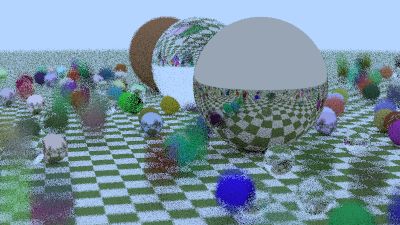

In [54]:
import Base.Threads.@threads
using Profile
using Random

# using Pkg; Pkg.add("ProgressMeter")
using ProgressMeter

# main render
function render()
    # make reproducible - this is thread local seed
    Random.seed!(1234)
    
    # get all scene info
    name,
    objects,
    background,
    lookfrom,
    lookat,
    vup,
    vfov,
    time0, 
    time1,
    dist_to_focus,
    aperture =
        get_scene(5)    
    
    # get image quality and size
    aspect_ratio, image_width, samples_per_pixel, max_depth =
        get_image_quality(SmallFast)    
    #aspect_ratio = 3/2
    #image_width = 400
    #samples_per_pixel = 2
    #max_depth = 3

    # derived items
    image_height = convert(Int,round(image_width/aspect_ratio))
    camera = Camera(lookfrom, lookat, vup, vfov, aspect_ratio, aperture, dist_to_focus, time0, time1)

    image = Array{Float64}(undef,3,image_height,image_width)
    
    # reset stats
    global scatter_count = 0

    open("raytrace_$(name)_$(image_width).ppm","w") do f # this pattern closes file on exit of scope
        print(f,"P3\n$image_width $image_height\n255\n") # header
        
        # Threads.@threads # put this in front of for loop for threads - not in Jupyter?
        
        @showprogress 1 "Computing..." for j1 in 1:image_height        
            # println("Thread $(Threads.threadid())")
            j = image_height-j1-1
            for i1 in 1:image_width
                i = i1-1
                # i,j = 62,221
                #print("IJ $i $j ")
                color = Color(0.0,0.0,0.0)
                # i,j = image_width/2,image_height/2
                for s in 1:samples_per_pixel
                    u = (convert(Float64,i)+random_double())/(image_width-1)
                    v = (convert(Float64,j)+random_double())/(image_height-1)
                    r = get_ray(camera,u,v)
                    color += ray_color(r, background, objects, max_depth)
                    #print(" $s ")
                end
                #print(" #1 ")
                color = clean_color(color,samples_per_pixel)
                write(f,"$color\n")
                image[1,j1,i1] = color[1]
                image[2,j1,i1] = color[2]
                image[3,j1,i1] = color[3]
                #return
            end
            # print(".") # progress indicator
        end    
    end # open
    # println("")
    println("Scatter count $scatter_count")
    # show
    colorview(RGB,image)
end

@time render()

# Profile.clear(); @profile render(); Profile.print()


In [39]:
# Profile.print();

In [ ]:
#=
TODO
- add textures from images
- get bounding volumes working
- threading, hard to do in jupyter
* better progress indicator, time, % done
- CSG
- switch to compiled VS Code development
- gather stats (hits, types, cutoffs, ray depths, reflections, scatter, etc...)
- don't save image till generated - don't partial overwrite
- change vector print back to float, special case the color PPM output
=#

The End!